# Production Planning/Lot-Sizing Problem

We start by importing the packages we will need.

In [36]:
using JuMP
using HiGHS
using LinearAlgebra
using Plots
using Statistics
using Test
using Pkg
Pkg.add("JLD2")
using JLD2

   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.10\Manifest.toml`


We provide randomly generated instances in a JLD2-file. 

In [37]:
# This structure will ease the passing of the specific instance for the functions 
# that generate and solve the optimization model.
mutable struct Instance
    nI     # Number of suppliers      
    nJ     # Number of demand points
    nT     # Number of periods
    I      # Supplier range
    J      # Demand points range
    T      # Periods range
    C      # Unit capacity costs per supplier
    H      # Unit storage cost per supplier
    M      # Production cost per supplier
    D      # Client demands in all periods
    Q      # Unit costs of unfulfilled demand
    F      # Unit costs to fulfill demands 
end

## ``solve_deterministic`` function

The function ```solve_deterministic()``` generates and solves the deterministic model. We also consider a keyword argument (following the semicolon) to turn off any printing in the code.


In [38]:
function solve_deterministic(ins::Instance; verbose = true)
    
    ## Renaming for making the implementation clearer
    I = ins.I
    J = ins.J
    T = ins.T 
    C = ins.C
    H = ins.H
    M = ins.M
    D = ins.D
    Q = ins.Q
    F = ins.F
    
    
    model = Model(HiGHS.Optimizer)                      # We use HiGHS solver

    ## Variables
    @variable(model, x[i in I] >= 0)                    # Capacity per supplier
    @variable(model, p[i in I, t in T] >= 0)            # Units produced per supplier per period
    @variable(model, k[i in I, t = 0:ins.nT] >= 0)            # Units stored in each supplier and period
    @variable(model, e[i in I, j in J, t in T] >= 0)    # Units transported from supplier i to demand point j at period t
    @variable(model, u[j in J, t in T] >= 0)            # Unfulfilled demand per demand point and period

    fix.(k[I, 0], 0; force = true)


    
    ## Objective: Minimize the total costs
    @objective(model, Min, 
        sum( C[i]*x[i] for i in I ) 
        + sum( H[i]*k[i,t] + M[i]*p[i,t] for t in T for i in I )
        + sum( F[i,j]*e[i,j,t] for t in T for j in J for i in I ) 
        + sum( Q[j]*u[j,t] for t in T for j in J )
    )




    
    ## Constraints
    @constraints(model, begin
            supply_limit[i = I, t = T], p[i,t] <= x[i]
            transition[i = I, t = T], p[i,t] + k[i, t-1] == sum( e[i,j,t] for j in J) + k[i,t] 
            demand[j = J, t = T], sum( e[i,j,t] for i in I ) == D[j,t] - u[j,t]
        end)





    
    if !verbose
        set_silent(model)                     # Omit solver log
    end
    optimize!(model)                          # Solve the problem
    status = termination_status(model)        # Solution status
    if verbose
        println("Model status = $(status)")   # Print status
    end
    
    return (x,p,k,e,u)
end;

Check if we got the correct x-values for the solution. 

In [39]:
test_ins = load("hw1_data.jld2", "test_ins");

(x_det_test,p_det_test,k_det_test,e_det_test,u_det_test) = solve_deterministic(test_ins, verbose = true)

if isa(x_det_test, Array)
    @test all(round.(value.(x_det_test), digits = 3) .≈ [1.105; 2.210; 3.315; 4.421; 5.526])
else
    @test all(round.(value.(x_det_test).data, digits = 3) .≈ [1.105; 2.210; 3.315; 4.421; 5.526])
end

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
75 rows, 205 cols, 395 nonzeros
70 rows, 200 cols, 385 nonzeros
Presolve : Reductions: rows 70(-5); columns 200(-10); elements 385(-15)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 25(82.8845) 0s
        123     1.6657689375e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 123
Objective value     :  1.6657689375e+02
HiGHS run time      :          0.00
Model status = OPTIMAL


Test Passed

In [40]:
i_prod = 1
println("Capacity of producer $(i_prod) is chosen to be $(value.(x_det_test).data[i_prod])\n")

# Save the solutions into variables for easier access
p_det_test_sol = value.(p_det_test).data
e_det_test_sol = value.(e_det_test).data
k_det_test_sol = value.(k_det_test).data
for t in test_ins.T
    println("Period $t:")
    println("Production p is $(round(p_det_test_sol[i_prod,t], digits=3))")
    println("Sum of deliveries is $(round(sum(e_det_test_sol[i_prod,:,t]), digits=3))")
    println("Storage k after period $t is $(round(k_det_test_sol[i_prod,t], digits=3))\n")
end

Capacity of producer 1 is chosen to be 1.10512625

Period 1:
Production p is 1.105
Sum of deliveries is 1.0
Storage k after period 1 is 0.0

Period 2:
Production p is 1.105
Sum of deliveries is 1.05
Storage k after period 2 is 0.105

Period 3:
Production p is 1.105
Sum of deliveries is 1.102
Storage k after period 3 is 0.16

Period 4:
Production p is 1.105
Sum of deliveries is 1.158
Storage k after period 4 is 0.163

Period 5:
Production p is 1.105
Sum of deliveries is 1.216
Storage k after period 5 is 0.11



## ``solve_stochastic()`` function


Notice that the object ```model``` has been already predefined and that the total number of scenarios ```nS``` as well as the probabilities ```Ps``` and demands ```d_sto``` for all scenarios are given as an arguments of the function.

In [41]:
function solve_stochastic(ins::Instance, nS, Ps, D_sto; verbose=true)
    ## D_sto is a 3-dimensional array with indices s, j and t, in this order.

    ## Ps contains the scenario probabilities. In this exercise, these are all the same: 1/nS.

    ## Renaming for making the implementation clearer    
    I = ins.I
    J = ins.J
    T = ins.T 
    C = ins.C
    H = ins.H
    M = ins.M
    Q = ins.Q
    F = ins.F
    
    S = 1:nS    # set of scenarios 
    
    model = Model(HiGHS.Optimizer)      

    ## Variables
    # Deterministic Variables
    @variable(model, x[i = I], lower_bound = 0, base_name = "x(i)")

    # Stochastic Variables
    @variables(model, begin
        k[i = I, t = 0:ins.nT, s = S], (lower_bound = 0, base_name = "k(i,t,s)")
        p[i = I, t = T, s = S], (lower_bound = 0, base_name = "p(i,t,s)")
        e[i = I, j = J, t = T, s = S], (lower_bound = 0, base_name = "e(i,j,t,s)")
        u[j = J, t = T, s = S], (lower_bound = 0, base_name = "u(j,t,s)")
    end)
    fix.(k[I, 0, S], 0; force = true)






    ## Objective: Minimize the total first-stage + second-stage costs over all scenarios
    @expression(model, det_cost, sum(C[i]*x[i] for i in I))
    @expression(model, sto_cost, 
        sum(Ps[s]*(
            sum((H[i]*k[i,t,s] + M[i]*p[i,t,s]) for t in T for i in I) + sum(F[i,j]*e[i,j,t,s] for t in T for j in J for i in I) + sum(Q[j]*u[j,t,s] for t in T for j in J)
        ) for s in S)
    )

    @objective(model, Min, det_cost + sto_cost)








    ## Constraints
     @constraints(model, begin
        supply_limit[i = I, t = T, s = S], p[i,t,s] <= x[i]
        transition[i = I, t = T, s = S], p[i, t, s] + k[i, t-1, s] == sum(e[i,j,t,s] for j in J) + k[i,t,s]
        demand[j = J, t = T, s = S], sum(e[i,j,t,s] for i in I) == D_sto[s,j,t] - u[j,t,s]
    end)











    
    if verbose 
        println("Solving stochastic model with $(nS) scenarios...")    
    else
        set_silent(model)                     # Omit solver log
    end
    optimize!(model)                           # Solve the problem

    status = termination_status(model)         # Solution status
    
    if verbose 
        println(status)                        # Print status
    end
    
    return (x,p,k,e,u)
end;

Loading in the data:

In [42]:
nS_test = load("hw1_data.jld2", "nS_test")
D_sto_test = load("hw1_data.jld2", "D_sto_test")
Ps_test = load("hw1_data.jld2", "Ps_test");

Testing the x-values:

In [43]:
(x_sto_test, p_sto_test, k_sto_test, e_sto_test, u_sto_test) = solve_stochastic(test_ins, nS_test, Ps_test, D_sto_test, verbose = true)

if isa(x_sto_test, Array)
    @test all(round.(value.(x_sto_test), digits=2) .≈ [1.12; 2.22; 3.36; 4.47; 5.59])
else
    @test all(round.(value.(x_sto_test).data, digits=2) .≈ [1.12; 2.22; 3.36; 4.47; 5.59])
end

Solving stochastic model with 10 scenarios...
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
750 rows, 2005 cols, 3950 nonzeros
700 rows, 1955 cols, 3850 nonzeros
Presolve : Reductions: rows 700(-50); columns 1955(-100); elements 3850(-150)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 250(825.696) 0s
        992     1.6699472693e+02 Pr: 0(0); Du: 0(2.58127e-15) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 992
Objective value     :  1.6699472693e+02
HiGHS run time      :          0.03
OPTIMAL


Test Passed

The cell below allows for plotting all the demand profiles (each demand scenario) for a predefined location $i$. You can observe how the demand behaves through time and how the variability increases as we look further in the future.

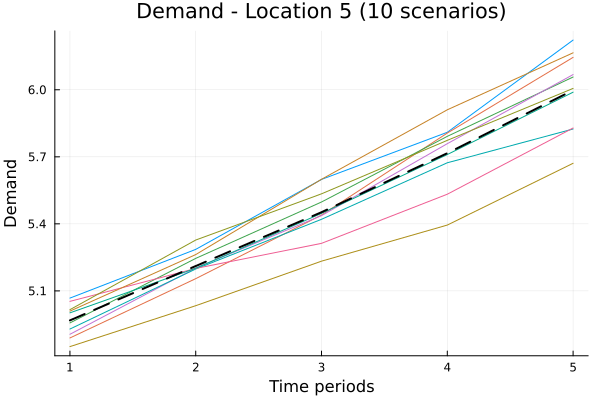

In [44]:
## Plotting the scenarios for a single locatiom
i = 5 # selected location for plotting

## Creating empty plot
plt = plot(
    xlabel = "Time periods",
    ylabel = "Demand",  
    title = "Demand - Location $(i) ($(nS_test) scenarios)",
    legend = false, fmt = :png
)

## Including each demand series in the plot
for s in 1:nS_test                               
    plot!(D_sto_test[s,i,:], legend = false)
end

## Plotting the expected demand 
plot!(sum(Ps_test[s]*D_sto_test[s,i,:] for s in 1:nS_test), 
    lw = 2,          # line weight
    ls = :dash,      # line stroke
    color = :black, 
    legend = false
)

plt

## Checking the runtime of the stochastic model

In [46]:
times_sto = []

for i in 1:5
    stats_sto = @timed solve_stochastic(test_ins, nS_test, Ps_test, D_sto_test, verbose = false);
    push!(times_sto, stats_sto.time)
end
mean_time_sto = mean(times_sto)

times_sto
println("Stochastic model solved in $(mean_time_sto) seconds.")

Stochastic model solved in 0.06214878 seconds.
